# Project : Text Summarization

Text summarization is the technique for generating a concise and precise summary of voluminous texts while focusing on the sections that convey useful information, and without losing the overall meaning.

Automatic text summarization aims to transform lengthy documents into shortened versions, something which could be difficult and costly to undertake if done manually.

Machine learning algorithms can be trained to comprehend documents and identify the sections that convey important facts and information before producing the required summarized texts. 

In this example, we want to summarize the information found on Wikipedia article.

# Two simple ways to scrape text from Wikipedia

1) Easy way: wikipedia library

2) General way: urllib and BeautifulSoup libraries

1) Easy way: wikipedia

In [1]:
# Import packages
import wikipedia

# Specify the title of the Wikipedia page
wiki = wikipedia.page('Elon Reeve Musk')

# Extract the plain text content of the page, excluding images, tables, and other data.
text = wiki.content

# Replace '==' with '' (an empty string)
text = text.replace('==', '')

# Replace '\n' (a new line) with '' & end the string at $1000.
text = text.replace('\n', '')[:-12]

2) General way: urllib and BeautifulSoup

In [2]:
import bs4 as BeautifulSoup
import urllib.request  
import re

# Fetching the content from the URL
fetched_data = urllib.request.urlopen('https://en.wikipedia.org/wiki/Elon_Musk')

article_read = fetched_data.read()

# Parsing the URL content and storing in a variable
article_parsed = BeautifulSoup.BeautifulSoup(article_read,'html.parser')

# Returning <p> tags
paragraphs = article_parsed.find_all('p')

article_content = ''

# Looping through the paragraphs and adding them to the variable
for p in paragraphs:  
    article_content += p.text
    
# Drop footnote superscripts in brackets
text = re.sub(r"\[.*?\]+", '', article_content)

# Replace '\n' (a new line) with '' and end the string at $1000.
text = text.replace('\n', '')[:-11]

# Step 1 : Preparing the data 

Here We're using beautifulSoup library

The BeautifulSoup library is used for parsing the page while the urllib library is used for connecting to the page and retrieving the HTML.
BeautifulSoup converts the incoming text to Unicode characters and the outgoing text to UTF-8 characters, saving you the hassle of managing different charset encodings while scraping text from the web.

We’ll use the urlopen function from the urllib.request utility to open the web page. Then, we’ll use the read function to read the scraped data object. 

For parsing the data, we’ll call the BeautifulSoup object and pass two parameters to it; that is, the article_read and the html.parser.

The find_all function is used to return all the <p> elements present in the HTML. Furthermore, using .text enables us to select only the texts found within the <p> elements.

In [3]:
import bs4 as BeautifulSoup
import urllib.request  

# Fetching the content from the URL
fetched_data = urllib.request.urlopen('https://en.wikipedia.org/wiki/Elon_Musk')

article_read = fetched_data.read()

# Parsing the URL content and storing in a variable
article_parsed = BeautifulSoup.BeautifulSoup(article_read,'html.parser')

# Returning <p> tags
paragraphs = article_parsed.find_all('p')

article_content = ''

# Looping through the paragraphs and adding them to the variable
for p in paragraphs:  
    article_content += p.text

# Step 2 : Processing the data 

To ensure the scrapped textual data is as noise-free as possible, we’ll perform some basic text cleaning.  
To assist us to do the processing, we’ll import a list of stopwords from the nltk library.
Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words.

We’ll also import PorterStemmer, which is an algorithm for reducing words into their root forms. For example, cleaning, cleaned, and cleaner can be reduced to the root clean.

Furthermore, we’ll create a dictionary table having the frequency of occurrence of each of the words in the text. We’ll loop through the text and the corresponding words to eliminate any stop words.

Then, we’ll check if the words are present in the frequency_table. If the word was previously available in the dictionary, its value is increased by 1. Otherwise, if the word is recognized for the first time, its value is set to 1.

In [4]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

def _create_dictionary_table(text_string) -> dict:
    
    # Removing stop words
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text_string)
    
    # Reducing words to their root form
    stem = PorterStemmer()
    
    # Creating dictionary for the word frequency table
    frequency_table = dict()
    for wd in words:
        wd = stem.stem(wd)
        if wd in stop_words:
            continue
        if wd in frequency_table:
            frequency_table[wd] += 1
        else:
            frequency_table[wd] = 1

    return frequency_table

# Step 3:  Tokenizing the article into sentences

Tokenizing the sentences is done to get all the words present in the sentences.

To split the article_content into a set of sentences, we’ll use the built-in method from the nltk library.

In [5]:
from nltk.tokenize import word_tokenize, sent_tokenize

sentences = sent_tokenize(article_content)

# Step 4: Finding the weighted frequencies of the sentences

To evaluate the score for every sentence in the text, we’ll be analyzing the frequency of occurrence of each term.
In this case, we’ll be scoring each sentence by its words; that is, adding the frequency of each important word found in the sentence.

Importantly, to ensure long sentences do not have unnecessarily high scores over short sentences, we divided each score of a sentence by the number of words found in that sentence.

Also, to optimize the dictionary’s memory, we arbitrarily added sentence[:7], which refers to the first 7 characters in each sentence. However, for longer documents, where you are likely to encounter sentences with the same first n_chars, it’s better to use hash functions or smart index functions to take into account such edge-cases and avoid collisions.

In [6]:
def _calculate_sentence_scores(sentences, frequency_table) -> dict:   

    # Algorithm for scoring a sentence by its words
    sentence_weight = dict()

    for sentence in sentences:
        sentence_wordcount = (len(word_tokenize(sentence)))
        sentence_wordcount_without_stop_words = 0
        for word_weight in frequency_table:
            if word_weight in sentence.lower():
                sentence_wordcount_without_stop_words += 1
                if sentence[:7] in sentence_weight:
                    sentence_weight[sentence[:7]] += frequency_table[word_weight]
                else:
                    sentence_weight[sentence[:7]] = frequency_table[word_weight]

        sentence_weight[sentence[:7]] = sentence_weight[sentence[:7]] / sentence_wordcount_without_stop_words
      
    return sentence_weight

# Step 5: Calculating the threshold of the sentences

To further tweak the kind of sentences eligible for summarization, we’ll create the average score for the sentences. With this threshold, we can avoid selecting the sentences with a lower score than the average score.


In [7]:
def _calculate_average_score(sentence_weight) -> int:
   
    # Calculating the average score for the sentences
    sum_values = 0
    for entry in sentence_weight:
        sum_values += sentence_weight[entry]

    # Getting sentence average value from source text
    average_score = (sum_values / len(sentence_weight))

    return average_score

# Step 6: Getting the summary

Lastly, since we have all the required parameters, we can now generate a summary for the article.

In [8]:
def _get_article_summary(sentences, sentence_weight, threshold):
    sentence_counter = 0
    article_summary = ''

    for sentence in sentences:
        if sentence[:7] in sentence_weight and sentence_weight[sentence[:7]] >= (threshold):
            article_summary += " " + sentence
            sentence_counter += 1

    return article_summary

#  Step 7: Final Step 

combining the above steps from 2 to 6

In [9]:
def _run_article_summary(article):
    
    #Processing the data
    frequency_table = _create_dictionary_table(article)

    #Tokenizing the article into sentences
    sentences = sent_tokenize(article)

    # Finding the weighted frequencies of the sentences
    sentence_scores = _calculate_sentence_scores(sentences, frequency_table)

    #Calculating the threshold of the sentences
    threshold = _calculate_average_score(sentence_scores)

    #Getting the summary
    article_summary = _get_article_summary(sentences, sentence_scores, 1.5 * threshold)
    
    return article_summary

# Step 8 : Print the Summary

In [10]:
summary_results = _run_article_summary(article_content)
print(summary_results)

 [5][6]
Musk was born in Pretoria, South Africa, where he grew up. [9] Musk has British and Pennsylvania Dutch ancestry. [14][17]
Musk's family was wealthy during his youth. [18][19][20] After his parents divorced in 1980, Musk mostly lived with his father. [21] He has a paternal half-sister and a half-brother. [18][22]
In his biography, Ashlee Vance described Musk as an awkward and introverted child. [33] In 1990, he entered Queen's University in Kingston, Ontario. [53] Musk then returned as CEO of the merged company. [109] A cross-over, the Model X was launched in 2015. [170]
In 2017, Musk founded The Boring Company to construct tunnels. [222] Later that year, Musk unveiled the concept, which he dubbed the hyperloop. [260]
At the start of 2020, Musk had a net worth of $27 billion. [262] During this, Musk's net worth was often volatile. [382] After his death, the couple decided to use IVF to continue their family. [404] The child was eventually named "X AE A-XII" Musk, with "X" as a f

# generating Word Cloud

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

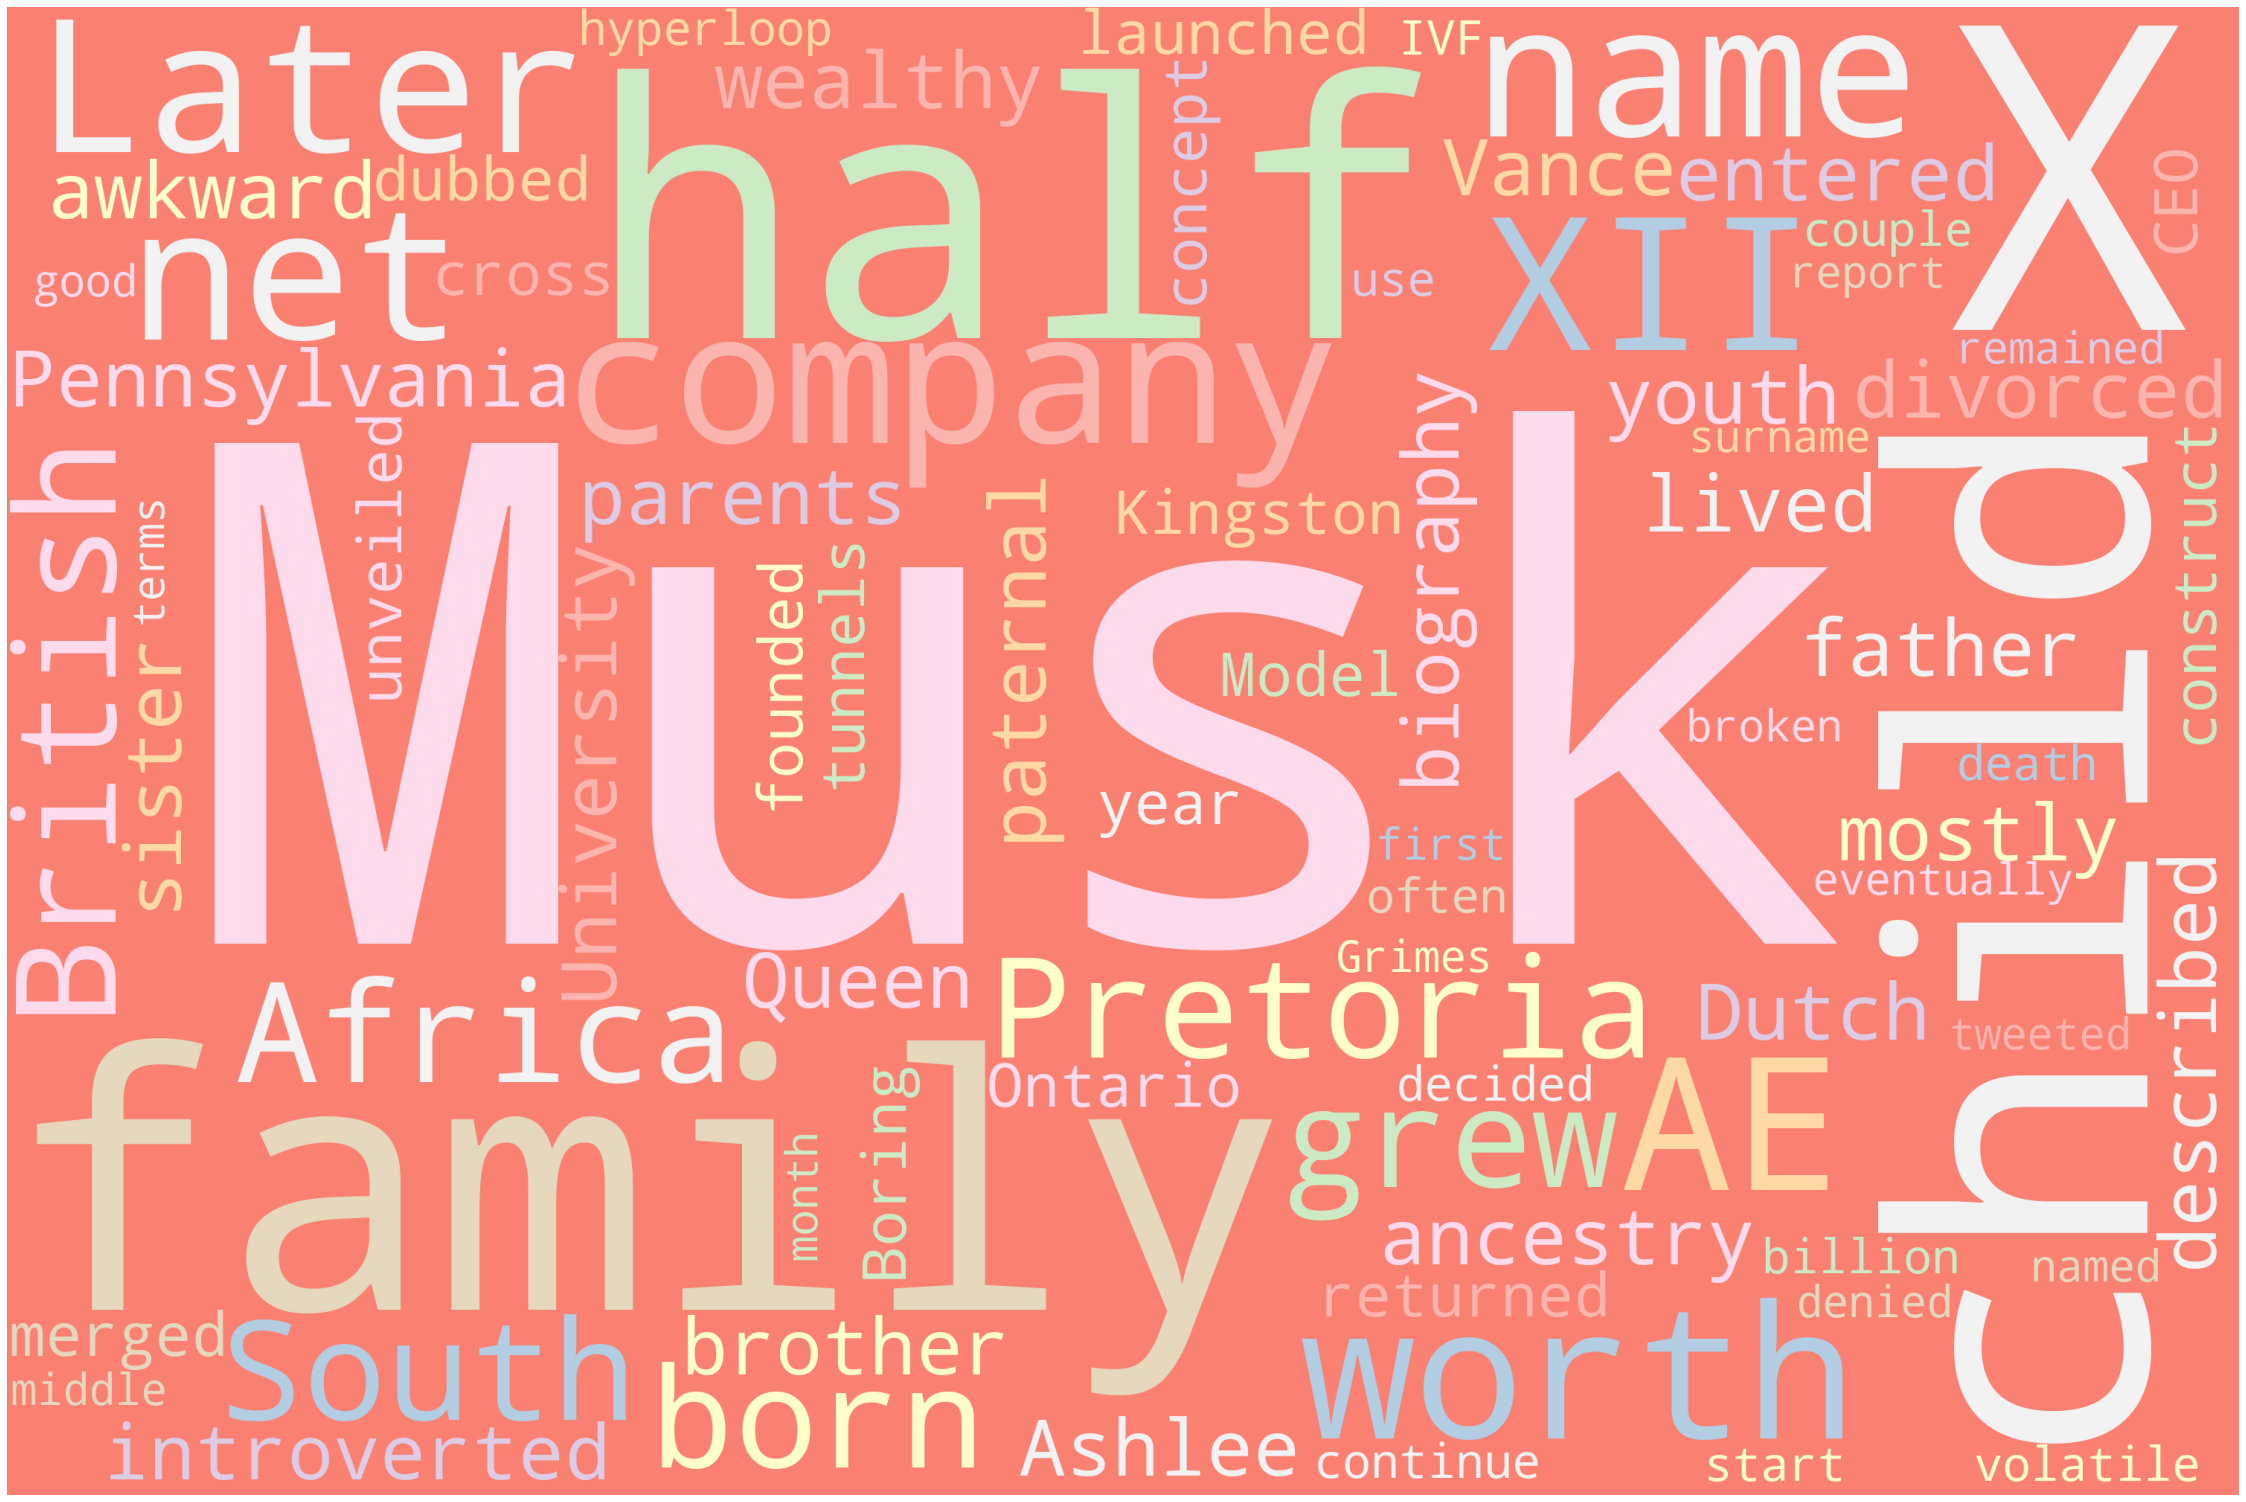

In [12]:
# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(summary_results)
# Plot
plot_cloud(wordcloud)